In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
import cv2
import os
plt.style.use('ggplot')
%matplotlib inline

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/mnist', validation_size=5000, one_hot=True)
test_len = mnist.test.images.shape[0]
validation_len = int(test_len * 0.1)
num_label=10
train_x = mnist.train.images
test_x = mnist.test.images[validation_len : test_len, :]
validation_x = mnist.test.images[ : validation_len, :]

train_y = mnist.train.labels
test_y = mnist.test.labels[validation_len : test_len]
validation_y = mnist.test.labels[ : validation_len]

print("\nTraining X shape: " + str(train_x.shape))
print("Testing X shape: " + str(test_x.shape))
print("Validation X shape: " + str(validation_x.shape))

print("\nTraining Y shape: " + str(train_y.shape))
print("Testing Y shape: " + str(test_y.shape))
print("Validation Y shape: " + str(validation_y.shape))

Extracting ./data/mnist/train-images-idx3-ubyte.gz
Extracting ./data/mnist/train-labels-idx1-ubyte.gz
Extracting ./data/mnist/t10k-images-idx3-ubyte.gz
Extracting ./data/mnist/t10k-labels-idx1-ubyte.gz

Training X shape: (55000, 784)
Testing X shape: (9000, 784)
Validation X shape: (1000, 784)

Training Y shape: (55000, 10)
Testing Y shape: (9000, 10)
Validation Y shape: (1000, 10)


In [4]:
mnist.validation.images.shape[0]

5000

In [5]:
import scipy.io as sio
import scipy.misc as scimisc
safe_list = [0,2,5,6,8,12,13,14,15,16,17,18,19,21,26]  # other alphabets have characters which look like digits
m = sio.loadmat("./data/data_background.mat")

squished_set = []
for safe_number in safe_list:
    for alphabet in m['images'][safe_number]:
        for letters in alphabet:
            for letter in letters:
                for example in letter:
                    squished_set.append(scimisc.imresize(1 - example[0], (28,28)).reshape(1, 28*28))

omnilog = np.concatenate(squished_set, axis=0)

/home/senqi/anaconda3/lib/python3.5/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/senqi/anaconda3/lib/python3.5/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [6]:
img_size = 28
img_flat_size = img_size * img_size
folders_notMNIST = os.listdir('./notMNIST_small')

NotMNIST_x_list = []
NotMNIST_y_list = []

for idx, folder in enumerate(folders_notMNIST):
    files_notMNIST = os.listdir('./notMNIST_small/' + folder)
    
    for file in files_notMNIST:
        img_NotMNIST = cv2.imread('./notMNIST_small/' + folder + '/' + file, 0)
        NotMNIST_flat = np.reshape(img_NotMNIST, (img_flat_size))
        NotMNIST_x_list.append(NotMNIST_flat)
        
        label_temp = np.zeros([num_label])
        label_temp[idx] = 1
        
        NotMNIST_y_list.append(label_temp)
        
NotMNIST_x = np.stack(NotMNIST_x_list, axis = 0)
NotMNIST_y = np.stack(NotMNIST_y_list, axis = 0)
NotMNIST_x = NotMNIST_x/255
print("NotMNIST X shape: " + str(NotMNIST_x.shape))
print("NotMNIST Y shape: " + str(NotMNIST_y.shape))

NotMNIST X shape: (18724, 784)
NotMNIST Y shape: (18724, 10)


In [33]:
M = 100
n_intergal_sample = 50
D=7*7*64
h1=512
D2=10
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
# variables
X = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None,10])
b = tf.placeholder(tf.bool,shape=(),name='b')
learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

w_conv1 = tf.get_variable('w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())

w_fc1 = tf.get_variable('w_fc1', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1 = tf.get_variable('b_fc1', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2 = tf.get_variable('w_fc2', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_r = tf.get_variable('w_fc1_sigma', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1_r = tf.get_variable('b_fc1_sigma', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2_r = tf.get_variable('w_fc2_sigma', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2_r = tf.get_variable('b_fc2_sigma', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_sigma = w_fc1_r**2
b_fc1_sigma = b_fc1_r**2
w_fc2_sigma = w_fc2_r**2
b_fc2_sigma = b_fc2_r**2

eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps3 = tf.random_normal(shape=[n_intergal_sample,h1,D2], mean=0.0, stddev=1,dtype=tf.float32)
eps4 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)

w0 = w_fc1 + eps1 * w_fc1_sigma
b0 = b_fc1 + eps2 * b_fc1_sigma
w1 = w_fc2 + eps3 * w_fc2_sigma
b1 = b_fc2 + eps4 * b_fc2_sigma
'''
eps11 = tf.reshape(eps1,[n_intergal_sample,D*h1])
eps22 = tf.reshape(eps2,[n_intergal_sample,1*h1])
eps33 = tf.reshape(eps3,[n_intergal_sample,h1*D2])
eps44 = tf.reshape(eps4,[n_intergal_sample,1*D2])

input_latent = tf.concat([eps11,eps22,eps33,eps44],1)
hidden1 = tf.layers.dense(input_latent, 15, activation=tf.nn.relu)
#hidden2 = tf.layers.dense(hidden1, 5, activation=tf.nn.relu)
#hidden3 = tf.layers.dense(hidden2, 30, activation=tf.nn.relu)
output_latent = tf.layers.dense(hidden1,(D*h1 + 1*h1+ h1*D2 + 1*D2), activation=None)

w0 = tf.reshape(output_latent[:,0:D*h1],[n_intergal_sample,D,h1])
b0 = tf.reshape(output_latent[:,D*h1:D*h1+1*h1],[n_intergal_sample,1,h1])
w1 = tf.reshape(output_latent[:,D*h1+1*h1:D*h1+1*h1+h1*D2],[n_intergal_sample,h1,D2])
b1 = tf.reshape(output_latent[:,D*h1+1*h1+h1*D2:D*h1+1*h1+h1*D2+1*D2],[n_intergal_sample,1,D2])
'''
# network
def network(X):
    con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_conv1 = tf.nn.relu(tf.layers.batch_normalization(con1, training=b))
    #h_conv1 = tf.nn.relu(con1)
    h_pool1 = max_pool_2x2(h_conv1)

    con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_conv2 = tf.nn.relu(tf.layers.batch_normalization(con2, training=b))
    #h_conv2 = tf.nn.relu(con2)
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool2_flat = tf.layers.flatten(h_pool2)
    h_pool2_flat1 = tf.stack([h_pool2_flat]*n_intergal_sample)

    h = tf.nn.relu(tf.matmul(h_pool2_flat1, w0) + b0)
    logits = tf.matmul(h, w1) + b1
    return tf.nn.softmax(logits)#num_sample*batch*10

#evaluation
output0 = network(X)
probs = tf.reduce_sum(output0*Y,2)
prob=tf.reduce_mean(probs,0)#积分
log_prob = tf.log(prob)#取log
p = tf.reduce_mean(log_prob)#求和

output, var0 = tf.nn.moments(output0,0)#batch*10
prob1 = tf.reduce_sum(output*Y,1)

max_p = tf.reduce_max(output,1)
ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)
Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-11)*output0,2),0)
MI = ent - Eent

correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

batch_noise = 100
noise = tf.reshape(tf.random_normal(shape=[1,784*M], mean=0.0, stddev=1, dtype=tf.float32),[M,28,28,1])
#noise = tf.reshape(tf.random_normal(shape=[1,784*M], mean=0.0, stddev=2, dtype=tf.float32),[M,28,28,1])
#noise = tf.abs(noise)
#noise = (noise - tf.reduce_min(noise))/(tf.reduce_max(noise) - tf.reduce_min(noise))
output1 = network(noise)
output_noise, varent_noise = tf.nn.moments(output1,0)
ent_noise = tf.reduce_sum(-tf.log(output_noise+1e-11)*output_noise,1)
Eent_noise = tf.reduce_mean(tf.reduce_sum(-tf.log(output1+1e-11)*output1,2),0)
MI_noise = ent_noise - Eent_noise
relularization = tf.reduce_mean(tf.square(w_fc1))*1e-4 + tf.reduce_mean(tf.square(b_fc1))*1e-4 + tf.reduce_mean(tf.square(w_fc2))*1e-4 + tf.reduce_mean(tf.square(b_fc2))*1e-4
pp = p + MI_noise*0.7 + relularization
# training

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(-pp)
saver = tf.train.Saver(max_to_keep=250)

with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_try/classification_mnist60/model.ckpt")
    for i in range(80000):
        batch = mnist.train.next_batch(M)
        x_batch = np.reshape(batch[0],[M, 28, 28, 1])
        y_batch = batch[1]
        if i%100==0:
            test_accuracy = []
            validation_accuracy = []
            maxp_in = []
            ent_in = []
            MI_in = []
            for j in range(0,100):
                imgs_in = mnist.test.images[j*100:(j+1)*100]
                labels_in = mnist.test.labels[j*100:(j+1)*100]
                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,28,28,1]),Y:labels_in,b:False})
                maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                MI_in1 = sess.run(MI,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                MI_in.extend(MI_in1)
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            MI_in = np.array(MI_in)
            
            for v in range(0,50):
                imgs_validation = mnist.validation.images[v*100:(v+1)*100]
                labels_validation = mnist.validation.labels[v*100:(v+1)*100]
                ac = sess.run(accuracy,{X:np.reshape(imgs_validation,[100,28,28,1]),Y:labels_validation,b:False})
                validation_accuracy.append(ac)
            validation_accuracy = np.array(validation_accuracy)
            validation_accuracy = np.mean(validation_accuracy)
            print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
            
            for t in range(0,4):
                if t == 0:
                    safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("gauss noise:")
                if t == 1:
                    safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("average noise:")
                if t == 2:
                    safe_images = omnilog
                    print("omnilog:")
                if t == 3:
                    safe_images = NotMNIST_x[:9200]
                    print("notmnist:")
                maxp_OOD = []
                ent_OOD = []
                MI_OOD = []
                    
                for k in range(0,92):
                    imgs_OOD = safe_images[k*100:(k+1)*100]
                    maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    MI_OOD1 = sess.run(MI,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    maxp_OOD.extend(maxp_OOD1)
                    ent_OOD.extend(ent_OOD1)
                    MI_OOD.extend(MI_OOD1)
                maxp_OOD = np.array(maxp_OOD)
                ent_OOD = np.array(ent_OOD)
                MI_OOD = np.array(MI_OOD)
                '''
                print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                '''
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                
                
                safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                print("----------------------------------------")
            print("############################################")
           
        if i < 6000:
            a = 0.0001
        elif i < 12000:
            a = 0.00005
        elif i < 24000:
            a = 0.00001
        elif i < 30000:
            a = 0.000005
        elif i < 36000:
            a = 0.000002
        elif i < 42000:
            a = 0.000001
        elif i < 48000:
            a = 0.0000005
        else:
            a = 0.0000002
        sess.run(train_step,{X: x_batch, Y: y_batch, b:True, learning_rate:a})

        if i%500==0:
            save_path = saver.save(sess, "./try1/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

time: 0 33.2725510597229 test accuracy 0.1009 validation_error 0.099
gauss noise:
maxp_OOD: 0.0 0.1781155 0.011753417
maxp_inD: 0.0 0.1874074 0.008648037
ent_OOD: 2.205965 0.011988117 ent_in: 2.2240937 0.00707658
MI_OOD: 0.026229532 0.002627225 MI_in: 0.027378904 0.0029017187
AUPR_p: 77.19
AUROC_p: 75.05
AUPR_entropy: 30.04
AUROC_entropy: 9.13
AUPR_MI: 39.8
AUROC_MI: 38.51
----------------------------------------
average noise:
maxp_OOD: 0.0 0.18226966 0.008298612
maxp_inD: 0.0 0.1874074 0.008648037
ent_OOD: 2.221722 0.006348813 ent_in: 2.2240937 0.00707658
MI_OOD: 0.026979128 0.002516012 MI_in: 0.027378904 0.0029017187
AUPR_p: 63.13
AUROC_p: 66.98
AUPR_entropy: 40.23
AUROC_entropy: 40.17
AUPR_MI: 43.6
AUROC_MI: 45.23
----------------------------------------
omnilog:
maxp_OOD: 0.0 0.18892546 0.010705728
maxp_inD: 0.0 0.1874074 0.008648037
ent_OOD: 2.2234244 0.0072614606 ent_in: 2.2240937 0.00707658
MI_OOD: 0.026976869 0.0024671585 MI_in: 0.027378904 0.0029017187
AUPR_p: 48.09
AUROC_p: 

KeyboardInterrupt: 

In [28]:
noisedata = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])

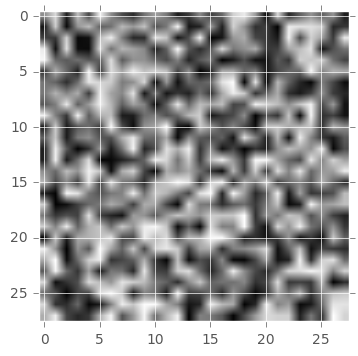

In [29]:
plt.imshow(noisedata[3].reshape(28,28),cmap='gray')
plt.show()

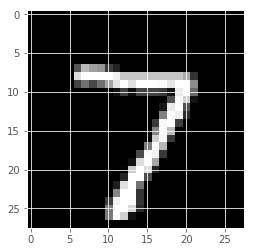

In [40]:
plt.imshow(mnist.test.images[0].reshape(28,28),cmap='gray')
plt.show()

## batch normalization switch

In [10]:
M = 100
n_intergal_sample = 50
D=7*7*64
h1=512
D2=10
max_AUC=0
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
# variables
X = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None,10])
b = tf.placeholder(tf.bool,shape=(),name='b')
learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

w_conv1 = tf.get_variable('w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())

w_fc1 = tf.get_variable('w_fc1', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1 = tf.get_variable('b_fc1', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2 = tf.get_variable('w_fc2', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_r = tf.get_variable('w_fc1_sigma', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1_r = tf.get_variable('b_fc1_sigma', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2_r = tf.get_variable('w_fc2_sigma', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2_r = tf.get_variable('b_fc2_sigma', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_sigma = w_fc1_r**2
b_fc1_sigma = b_fc1_r**2
w_fc2_sigma = w_fc2_r**2
b_fc2_sigma = b_fc2_r**2

eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps3 = tf.random_normal(shape=[n_intergal_sample,h1,D2], mean=0.0, stddev=1,dtype=tf.float32)
eps4 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)

w0 = w_fc1 + eps1 * w_fc1_sigma
b0 = b_fc1 + eps2 * b_fc1_sigma
w1 = w_fc2 + eps3 * w_fc2_sigma
b1 = b_fc2 + eps4 * b_fc2_sigma
'''
eps11 = tf.reshape(eps1,[n_intergal_sample,D*h1])
eps22 = tf.reshape(eps2,[n_intergal_sample,1*h1])
eps33 = tf.reshape(eps3,[n_intergal_sample,h1*D2])
eps44 = tf.reshape(eps4,[n_intergal_sample,1*D2])

input_latent = tf.concat([eps11,eps22,eps33,eps44],1)
hidden1 = tf.layers.dense(input_latent, 15, activation=tf.nn.relu)
#hidden2 = tf.layers.dense(hidden1, 5, activation=tf.nn.relu)
#hidden3 = tf.layers.dense(hidden2, 30, activation=tf.nn.relu)
output_latent = tf.layers.dense(hidden1,(D*h1 + 1*h1+ h1*D2 + 1*D2), activation=None)

w0 = tf.reshape(output_latent[:,0:D*h1],[n_intergal_sample,D,h1])
b0 = tf.reshape(output_latent[:,D*h1:D*h1+1*h1],[n_intergal_sample,1,h1])
w1 = tf.reshape(output_latent[:,D*h1+1*h1:D*h1+1*h1+h1*D2],[n_intergal_sample,h1,D2])
b1 = tf.reshape(output_latent[:,D*h1+1*h1+h1*D2:D*h1+1*h1+h1*D2+1*D2],[n_intergal_sample,1,D2])
'''
# network
def network(X):
    con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)
    h_pool1 = max_pool_2x2(h_conv1)

    con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool2_flat = tf.layers.flatten(h_pool2)
    h_pool2_flat1 = tf.stack([h_pool2_flat]*n_intergal_sample)

    h = tf.nn.relu(tf.matmul(h_pool2_flat1, w0) + b0)
    logits = tf.matmul(h, w1) + b1
    return tf.nn.softmax(logits)#num_sample*batch*10

#evaluation
output0 = network(X)
probs = tf.reduce_sum(output0*Y,2)
prob=tf.reduce_mean(probs,0)#积分
log_prob = tf.log(prob)#取log
p = tf.reduce_mean(log_prob)#求和

output, var0 = tf.nn.moments(output0,0)#batch*10
prob1 = tf.reduce_sum(output*Y,1)

max_p = tf.reduce_max(output,1)
ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)
Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-11)*output0,2),0)
MI = ent - Eent

correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

batch_noise = 100
noise = tf.reshape(tf.random_normal(shape=[1,784*M], mean=0.0, stddev=1, dtype=tf.float32),[M,28,28,1])
#noise = tf.reshape(tf.random_normal(shape=[1,784*M], mean=0.0, stddev=2, dtype=tf.float32),[M,28,28,1])
#noise = tf.abs(noise)
#noise = (noise - tf.reduce_min(noise))/(tf.reduce_max(noise) - tf.reduce_min(noise))
output1 = network(noise)
output_noise, varent_noise = tf.nn.moments(output1,0)
ent_noise = tf.reduce_sum(-tf.log(output_noise+1e-11)*output_noise,1)
Eent_noise = tf.reduce_mean(tf.reduce_sum(-tf.log(output1+1e-11)*output1,2),0)
MI_noise = ent_noise - Eent_noise
#relularization = tf.reduce_mean(tf.square(w_fc1))*1e-4 + tf.reduce_mean(tf.square(b_fc1))*1e-4 + tf.reduce_mean(tf.square(w_fc2))*1e-4 + tf.reduce_mean(tf.square(b_fc2))*1e-4
relularization = 1e-4*(tf.reduce_mean(tf.square(w_fc1)) + 
                       tf.reduce_mean(tf.square(b_fc1)) + 
                       tf.reduce_mean(tf.square(w_fc2)) + 
                       tf.reduce_mean(tf.square(b_fc2)) +
                       tf.reduce_mean(tf.square(w_conv1)) +
                       tf.reduce_mean(tf.square(w_conv2)))

pp = p + MI_noise*0.7 - relularization
# training

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(-pp)
saver = tf.train.Saver(max_to_keep=250)

with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_try/classification_mnist60/model.ckpt")
    for i in range(80000):
        batch = mnist.train.next_batch(M)
        x_batch = np.reshape(batch[0],[M, 28, 28, 1])
        y_batch = batch[1]
        if i%100==0:
            test_accuracy = []
            validation_accuracy = []
            maxp_in = []
            ent_in = []
            MI_in = []
            for j in range(0,100):
                imgs_in = mnist.test.images[j*100:(j+1)*100]
                labels_in = mnist.test.labels[j*100:(j+1)*100]
                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,28,28,1]),Y:labels_in,b:False})
                maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                MI_in1 = sess.run(MI,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                MI_in.extend(MI_in1)
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            MI_in = np.array(MI_in)
            
            for v in range(0,50):
                imgs_validation = mnist.validation.images[v*100:(v+1)*100]
                labels_validation = mnist.validation.labels[v*100:(v+1)*100]
                ac = sess.run(accuracy,{X:np.reshape(imgs_validation,[100,28,28,1]),Y:labels_validation,b:False})
                validation_accuracy.append(ac)
            validation_accuracy = np.array(validation_accuracy)
            validation_accuracy = np.mean(validation_accuracy)
            print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
            
            for t in range(0,2):
                if t == 10:
                    safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("gauss noise:")
                if t == 11:
                    safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("average noise:")
                if t == 0:
                    safe_images = omnilog
                    print("omnilog:")
                if t == 1:
                    safe_images = NotMNIST_x[:9200]
                    print("notmnist:")
                maxp_OOD = []
                ent_OOD = []
                MI_OOD = []
                    
                for k in range(0,92):
                    imgs_OOD = safe_images[k*100:(k+1)*100]
                    maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    MI_OOD1 = sess.run(MI,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    maxp_OOD.extend(maxp_OOD1)
                    ent_OOD.extend(ent_OOD1)
                    MI_OOD.extend(MI_OOD1)
                maxp_OOD = np.array(maxp_OOD)
                ent_OOD = np.array(ent_OOD)
                MI_OOD = np.array(MI_OOD)
                '''
                print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                '''
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                
                
                safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))
                if t == 0:
                    tmp_AUC = round(100*roc_auc_score(labels, examples), 2)

                safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                print("----------------------------------------")
            print("############################################")
           
        if i < 6000:
            a = 0.0001
        elif i < 12000:
            a = 0.00005
        elif i < 24000:
            a = 0.00001
        elif i < 30000:
            a = 0.000005
        elif i < 36000:
            a = 0.000002
        elif i < 42000:
            a = 0.000001
        elif i < 48000:
            a = 0.0000005
        else:
            a = 0.0000002
        sess.run(train_step,{X: x_batch, Y: y_batch, b:True, learning_rate:a})

        if i%100==0:
            if tmp_AUC>max_AUC:
                max_AUC = tmp_AUC
                save_path = saver.save(sess, "./try4/classification_mnist%s/model.ckpt" % model_id)
                model_id+=1
                print("best model ",model_id," saved", "test accuracy: ",test_accuracy, "AUC: ",max_AUC)
                print("############################################************************************")

time: 0 36.07919907569885 test accuracy 0.0935 validation_error 0.0854
omnilog:
maxp_OOD: 0.0 0.17489433 0.0067437333
maxp_inD: 0.0 0.17309625 0.0061897053
ent_OOD: 2.2055645 0.0056175175 ent_in: 2.2066398 0.0054309885
MI_OOD: 0.01337889 0.001576971 MI_in: 0.012988417 0.0015678488
AUPR_p: 43.42
AUROC_p: 41.95
AUPR_entropy: 44.15
AUROC_entropy: 44.61
AUPR_MI: 53.4
AUROC_MI: 58.0
----------------------------------------
notmnist:
maxp_OOD: 0.0 0.16810116 0.0063551264
maxp_inD: 0.0 0.17309625 0.0061897053
ent_OOD: 2.2024286 0.0063975407 ent_in: 2.2066398 0.0054309885
MI_OOD: 0.013035709 0.0017181385 MI_in: 0.012988417 0.0015678488
AUPR_p: 71.29
AUROC_p: 71.61
AUPR_entropy: 37.07
AUROC_entropy: 30.78
AUPR_MI: 49.79
AUROC_MI: 48.96
----------------------------------------
############################################
best model  1  saved test accuracy:  0.0935 AUC:  44.61
############################################************************************
time: 100 156.86361932754517 test accura

KeyboardInterrupt: 

In [100]:
M = 100
n_intergal_sample = 50
D=7*7*64
h1=512
D2=10
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"  
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

tf.reset_default_graph()
# variables
X = tf.placeholder(tf.float32, shape = [None, 28, 28, 1])
Y = tf.placeholder(tf.float32, [None,10])
b = tf.placeholder(tf.bool,shape=(),name='b')
learning_rate = tf.placeholder(tf.float32,shape=(),name='learning_rate')

w_conv1 = tf.get_variable('w_conv1', [5,5, 1,32], initializer = tf.contrib.layers.xavier_initializer())
w_conv2 = tf.get_variable('w_conv2', [5,5,32,64], initializer = tf.contrib.layers.xavier_initializer())

w_fc1 = tf.get_variable('w_fc1', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1 = tf.get_variable('b_fc1', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2 = tf.get_variable('w_fc2', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2 = tf.get_variable('b_fc2', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_r = tf.get_variable('w_fc1_sigma', [7*7*64, h1], initializer = tf.contrib.layers.xavier_initializer())
b_fc1_r = tf.get_variable('b_fc1_sigma', [1,h1], initializer = tf.contrib.layers.xavier_initializer())
w_fc2_r = tf.get_variable('w_fc2_sigma', [512, 10], initializer = tf.contrib.layers.xavier_initializer())
b_fc2_r = tf.get_variable('b_fc2_sigma', [1,10], initializer = tf.contrib.layers.xavier_initializer())

w_fc1_sigma = w_fc1_r**2
b_fc1_sigma = b_fc1_r**2
w_fc2_sigma = w_fc2_r**2
b_fc2_sigma = b_fc2_r**2

eps1 = tf.random_normal(shape=[n_intergal_sample,D,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps2 = tf.random_normal(shape=[n_intergal_sample,1,h1], mean=0.0, stddev=1,dtype=tf.float32)
eps3 = tf.random_normal(shape=[n_intergal_sample,h1,D2], mean=0.0, stddev=1,dtype=tf.float32)
eps4 = tf.random_normal(shape=[n_intergal_sample,1,D2], mean=0.0, stddev=1,dtype=tf.float32)

w0 = w_fc1 + eps1 * w_fc1_sigma
b0 = b_fc1 + eps2 * b_fc1_sigma
w1 = w_fc2 + eps3 * w_fc2_sigma
b1 = b_fc2 + eps4 * b_fc2_sigma
'''
eps11 = tf.reshape(eps1,[n_intergal_sample,D*h1])
eps22 = tf.reshape(eps2,[n_intergal_sample,1*h1])
eps33 = tf.reshape(eps3,[n_intergal_sample,h1*D2])
eps44 = tf.reshape(eps4,[n_intergal_sample,1*D2])

input_latent = tf.concat([eps11,eps22,eps33,eps44],1)
hidden1 = tf.layers.dense(input_latent, 15, activation=tf.nn.relu)
#hidden2 = tf.layers.dense(hidden1, 5, activation=tf.nn.relu)
#hidden3 = tf.layers.dense(hidden2, 30, activation=tf.nn.relu)
output_latent = tf.layers.dense(hidden1,(D*h1 + 1*h1+ h1*D2 + 1*D2), activation=None)

w0 = tf.reshape(output_latent[:,0:D*h1],[n_intergal_sample,D,h1])
b0 = tf.reshape(output_latent[:,D*h1:D*h1+1*h1],[n_intergal_sample,1,h1])
w1 = tf.reshape(output_latent[:,D*h1+1*h1:D*h1+1*h1+h1*D2],[n_intergal_sample,h1,D2])
b1 = tf.reshape(output_latent[:,D*h1+1*h1+h1*D2:D*h1+1*h1+h1*D2+1*D2],[n_intergal_sample,1,D2])
'''
# network
def network(X):
    con1 = tf.nn.conv2d(X, w_conv1, strides=[1, 1, 1, 1], padding='SAME')
    h_conv1 = tf.layers.batch_normalization(tf.nn.relu(con1), training=b)
    h_pool1 = max_pool_2x2(h_conv1)

    con2 = tf.nn.conv2d(h_pool1, w_conv2, strides=[1, 1, 1, 1], padding='SAME')
    h_conv2 = tf.layers.batch_normalization(tf.nn.relu(con2), training=b)
    h_pool2 = max_pool_2x2(h_conv2)

    h_pool2_flat = tf.layers.flatten(h_pool2)
    h_pool2_flat1 = tf.stack([h_pool2_flat]*n_intergal_sample)

    h = tf.nn.relu(tf.matmul(h_pool2_flat1, w0) + b0)
    logits = tf.matmul(h, w1) + b1
    return tf.nn.softmax(logits)#num_sample*batch*10

#evaluation
output0 = network(X)
probs = tf.reduce_sum(output0*Y,2)
prob=tf.reduce_mean(probs,0)#积分
log_prob = tf.log(prob)#取log
p = tf.reduce_mean(log_prob)#求和

output, var0 = tf.nn.moments(output0,0)#batch*10
prob1 = tf.reduce_sum(output*Y,1)

max_p = tf.reduce_max(output,1)
ent = tf.reduce_sum(-tf.log(output+1e-11)*output,1)
Eent = tf.reduce_mean(tf.reduce_sum(-tf.log(output0+1e-11)*output0,2),0)
MI = ent - Eent

correct_pred = tf.equal(tf.argmax(output,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

batch_noise = 100
noise = tf.reshape(tf.random_normal(shape=[1,784*M], mean=0.0, stddev=1, dtype=tf.float32),[M,28,28,1])
#noise = tf.reshape(tf.random_normal(shape=[1,784*M], mean=0.0, stddev=2, dtype=tf.float32),[M,28,28,1])
#noise = tf.abs(noise)
#noise = (noise - tf.reduce_min(noise))/(tf.reduce_max(noise) - tf.reduce_min(noise))
output1 = network(noise)
output_noise, varent_noise = tf.nn.moments(output1,0)
ent_noise = tf.reduce_sum(-tf.log(output_noise+1e-11)*output_noise,1)
Eent_noise = tf.reduce_mean(tf.reduce_sum(-tf.log(output1+1e-11)*output1,2),0)
MI_noise = ent_noise - Eent_noise
relularization = tf.reduce_mean(tf.square(w_fc1))*1e-4 + tf.reduce_mean(tf.square(b_fc1))*1e-4 + tf.reduce_mean(tf.square(w_fc2))*1e-4 + tf.reduce_mean(tf.square(b_fc2))*1e-4
pp = p + MI_noise*0.7 + relularization
# training

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(-pp)
saver = tf.train.Saver(max_to_keep=250)

with tf.Session() as sess:
    start_time = time.time()
    sess.run(tf.global_variables_initializer())
    model_id=0
    #save_path = saver.restore(sess, "./baseline_try/classification_mnist60/model.ckpt")
    for i in range(80000):
        batch = mnist.train.next_batch(M)
        x_batch = np.reshape(batch[0],[M, 28, 28, 1])
        y_batch = batch[1]
        if i%100==0:
            test_accuracy = []
            validation_accuracy = []
            maxp_in = []
            ent_in = []
            MI_in = []
            for j in range(0,100):
                imgs_in = mnist.test.images[j*100:(j+1)*100]
                labels_in = mnist.test.labels[j*100:(j+1)*100]
                acc = sess.run(accuracy,{X:np.reshape(imgs_in,[100,28,28,1]),Y:labels_in,b:False})
                maxp_in1 = sess.run(max_p,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                ent_in1 = sess.run(ent,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                MI_in1 = sess.run(MI,{X:np.reshape(imgs_in,[100,28,28,1]),b:False})
                test_accuracy.append(acc)
                maxp_in.extend(maxp_in1)
                ent_in.extend(ent_in1)
                MI_in.extend(MI_in1)
            test_accuracy = np.array(test_accuracy)
            test_accuracy = np.mean(test_accuracy)
            maxp_in = np.array(maxp_in)
            ent_in = np.array(ent_in)
            MI_in = np.array(MI_in)
            
            for v in range(0,50):
                imgs_validation = mnist.validation.images[v*100:(v+1)*100]
                labels_validation = mnist.validation.labels[v*100:(v+1)*100]
                ac = sess.run(accuracy,{X:np.reshape(imgs_validation,[100,28,28,1]),Y:labels_validation,b:False})
                validation_accuracy.append(ac)
            validation_accuracy = np.array(validation_accuracy)
            validation_accuracy = np.mean(validation_accuracy)
            print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
            
            for t in range(0,2):
                '''
                if t == 0:
                    safe_images = np.reshape(np.random.normal( 0.0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("gauss noise:")
                
                if t == 1:
                    safe_images = np.reshape(np.random.uniform(0, 1,[1,9200*784] ),[9200,28,28,1])
                    print("average noise:")
                '''
                if t == 0:
                    safe_images = omnilog
                    print("omnilog:")
                if t == 1:
                    safe_images = NotMNIST_x[:9200]
                    print("notmnist:")
                maxp_OOD = []
                ent_OOD = []
                MI_OOD = []
                    
                for k in range(0,92):
                    imgs_OOD = safe_images[k*100:(k+1)*100]
                    maxp_OOD1 = sess.run(max_p,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    ent_OOD1 = sess.run(ent,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    MI_OOD1 = sess.run(MI,{X:np.reshape(imgs_OOD,[100,28,28,1]),b:False})
                    maxp_OOD.extend(maxp_OOD1)
                    ent_OOD.extend(ent_OOD1)
                    MI_OOD.extend(MI_OOD1)
                maxp_OOD = np.array(maxp_OOD)
                ent_OOD = np.array(ent_OOD)
                MI_OOD = np.array(MI_OOD)
                '''
                print ("time:",i, time.time() - start_time, "test accuracy", test_accuracy, "validation_error",validation_accuracy)
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                '''
                print("maxp_OOD:",np.mean(maxp_OOD>0.99),np.mean(maxp_OOD),np.std(maxp_OOD))
                print("maxp_inD:",np.mean(maxp_in>0.99),np.mean(maxp_in),np.std(maxp_in))
                print("ent_OOD:",np.mean(ent_OOD),np.std(ent_OOD), "ent_in:", np.mean(ent_in),np.std(ent_in))
                print("MI_OOD:",np.mean(MI_OOD),np.std(MI_OOD), "MI_in:", np.mean(MI_in),np.std(MI_in))
                
                
                safe, risky = -np.reshape(maxp_in,[10000,1]), -np.reshape(maxp_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_p:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_p:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(ent_in,[10000,1]), np.reshape(ent_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_entropy:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_entropy:', round(100*roc_auc_score(labels, examples), 2))

                safe, risky = np.reshape(MI_in,[10000,1]), np.reshape(MI_OOD,[9200,1])
                labels = np.zeros((safe.shape[0] + risky.shape[0]), dtype=np.int32)
                labels[safe.shape[0]:] += 1
                examples = np.squeeze(np.vstack((safe, risky)))
                print('AUPR_MI:', round(100*average_precision_score(labels, examples), 2))
                print('AUROC_MI:', round(100*roc_auc_score(labels, examples), 2))
                print("----------------------------------------")
            print("############################################")
           
        if i < 6000:
            a = 0.0001
        elif i < 12000:
            a = 0.00005
        elif i < 24000:
            a = 0.00001
        elif i < 30000:
            a = 0.000005
        elif i < 36000:
            a = 0.000002
        elif i < 42000:
            a = 0.000001
        elif i < 48000:
            a = 0.0000005
        else:
            a = 0.0000002
        sess.run(train_step,{X: x_batch, Y: y_batch, b:True, learning_rate:a})

        if i%500==0:
            save_path = saver.save(sess, "./try2/classification_mnist%s/model.ckpt" % model_id)
            model_id+=1

time: 0 33.143675327301025 test accuracy 0.09879999 validation_error 0.10720001
omnilog:
maxp_OOD: 0.0 0.15957665 0.005227076
maxp_inD: 0.0 0.15911996 0.0044248872
ent_OOD: 2.2448828 0.00515965 ent_in: 2.2481813 0.0035800887
MI_OOD: 0.010234099 0.0011548634 MI_in: 0.010602351 0.0011923995
AUPR_p: 48.71
AUROC_p: 47.43
AUPR_entropy: 38.18
AUROC_entropy: 30.63
AUPR_MI: 42.01
AUROC_MI: 40.23
----------------------------------------
notmnist:
maxp_OOD: 0.0 0.15624885 0.0050242078
maxp_inD: 0.0 0.15911996 0.0044248872
ent_OOD: 2.2452538 0.0044712187 ent_in: 2.2481813 0.0035800887
MI_OOD: 0.010537944 0.0013059311 MI_in: 0.010602351 0.0011923995
AUPR_p: 66.45
AUROC_p: 66.35
AUPR_entropy: 37.58
AUROC_entropy: 30.38
AUPR_MI: 49.51
AUROC_MI: 47.13
----------------------------------------
############################################
time: 100 145.06529021263123 test accuracy 0.1469 validation_error 0.1524
omnilog:
maxp_OOD: 0.0 0.26147097 0.040202126
maxp_inD: 0.0 0.27374297 0.057300605
ent_OOD: 2

KeyboardInterrupt: 

In [9]:
12000/500

24.0

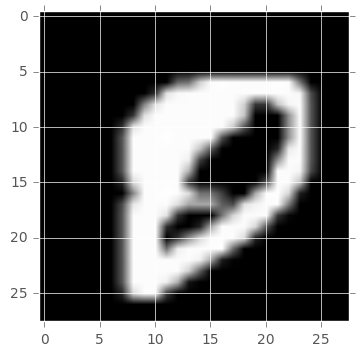

In [98]:
im = np.reshape((train_x[1979]*5+train_x[99]*0)/5,[1,28,28,1])
#im = train_x[1979]#omnilog[0]
img = np.reshape(im,[28,28])
plt.imshow(img,cmap='gray')
plt.show()

In [70]:
train_x[99]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     